## Transfer Learning

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


### Preparación de los datos

Obtengo los datos del dataset MNIST, que contiene imágenes de números:

In [ ]:
# Download train data from open datasets.
train_data_2b= datasets.MNIST(root='data', train=True, download=True, transform=ToTensor(),)

# Download test data from open datsets.
test_data_2b=datasets.MNIST(root='data', train=False, download=True, transform=ToTensor(),)

In [ ]:
print(train_data_2b)
print()
print(test_data_2b)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


El problema debe convertirse en un problema de clasificación binaria, por lo que, modifico las etiquetas.

En lugar de ser números del 0 al 9, los convierto en:  
  
0 -> Si es un número menor a 4.5  
1 -> Si es un número mayor a 4.5

In [ ]:
def modify_labels(data):
    return [(image, 0 if label <= 4.5 else 1) for image, label in data]

train_data_2b_cb = modify_labels(train_data_2b)
test_data_2b_cb = modify_labels(test_data_2b)

Distribución de las clases:

In [ ]:
def graphClasses(dataset):

  cb_images, cb_labels = zip(*[(bin_image, bin_label) for bin_image, bin_label in dataset])

  cb_counts = [cb_labels.count(0),  cb_labels.count(1)]
  cb_labels_descr = ['Menor a 4.5', 'Mayor a 4.5']

  plt.figure(figsize=(5, 5))
  plt.pie(cb_counts, labels=cb_labels_descr, autopct='%1.1f%%', startangle=90)
  plt.axis('equal')
  plt.title('Distribución de clases')
  plt.show()

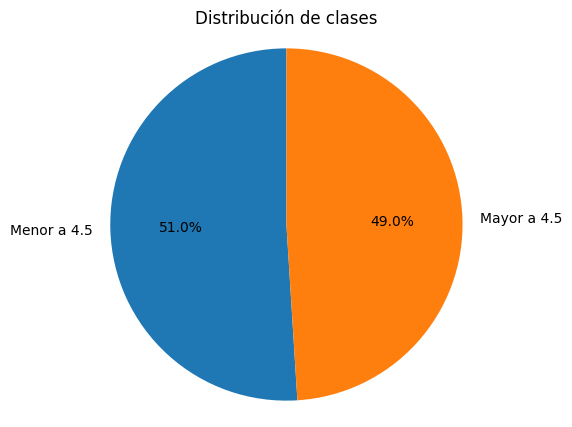

In [ ]:
graphClasses(train_data_2b_cb)

In [ ]:
print(f"Tamaño del set de entrenamiento: {len(train_data_2b_cb)}")


Tamaño del set de entrenamiento: 60000


Separo las 20000 filas del set de entrenamiento, asegurando que se mantenga la distribución de clases.

In [ ]:
cb_images, cb_labels = zip(*[(bin_image, bin_label) for bin_image, bin_label in train_data_2b_cb])

images_sampled, _, labels_sampled, _ = train_test_split(
    cb_images, cb_labels,
    train_size=20000,
    stratify=cb_labels,
    random_state=42
)

# Combinar imágenes y etiquetas en una nueva lista
train_data_2b_cb_sampled = list(zip(images_sampled, labels_sampled))



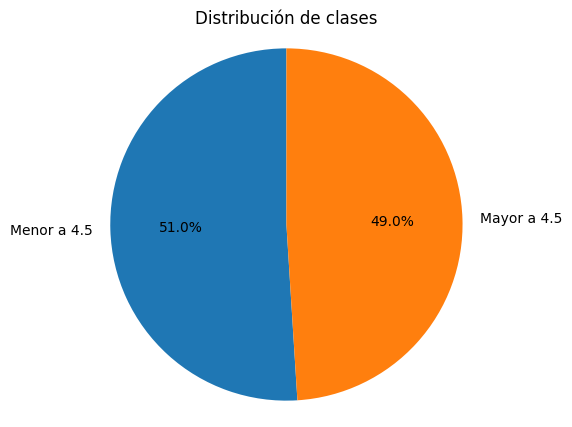

In [ ]:
graphClasses(train_data_2b_cb_sampled)

Verifico que la distribución se mantiene.  
Los tamaños de los sets de entrenamiento y validación resultan entonces:

In [ ]:
print(f"Tamaño del set de entrenamiento: {len(train_data_2b_cb_sampled)}")
print(f"Tamaño del set de validación: {len(test_data_2b_cb)}")

Tamaño del set de entrenamiento: 20000
Tamaño del set de validación: 10000


In [ ]:
batch_size = 64

# Dataloader
train_dataloader_2b =torch.utils.data.DataLoader(train_data_2b_cb_sampled, batch_size=batch_size, shuffle=True, pin_memory=True)
test_dataloader_2b =torch.utils.data.DataLoader(test_data_2b_cb, batch_size=batch_size, shuffle=False, pin_memory=True)

In [ ]:
# Ver imagen and label del dataloader
train_features_2b, train_labels_2b = next(iter(train_dataloader_2b))

print(f"Tamaño del batch de feature (input / imagen): {train_features_2b.size()}")
print(f"Tamaño del batch del label (clase / etiqueta): {train_labels_2b.size()}")


Tamaño del batch de feature (input / imagen): torch.Size([64, 1, 28, 28])
Tamaño del batch del label (clase / etiqueta): torch.Size([64])


Las imágenes tienen el mismo formato (28x28 y un sólo canal) por lo que, no es necesario aplicar ninguna transformación.

tamaño de 1 imagen:  torch.Size([1, 28, 28])
tamaño de 1 imagen DESPUES de squeeze:  torch.Size([28, 28])


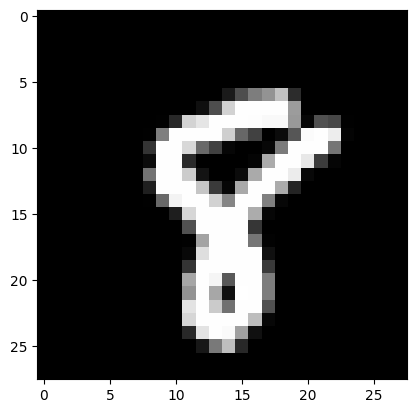

Label: 1


In [ ]:
img = train_features_2b[20]
print('tamaño de 1 imagen: ', img.shape)
# le QUITO 1 dimension (la del tamaño del batch) para poder graficar
img = img.squeeze()
print('tamaño de 1 imagen DESPUES de squeeze: ', img.shape)
label = train_labels_2b[20]

# ploteo esa imagen
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

### Transfer Learning

De las estrategias vistas en la teoría, selecciono las dos opciones más comunes:    
  
*Finetuning:*    
En lugar de inicializar de manera aleatoria, se inicializa la red con pesos pre-entrenados y se continúa con el entrenamiento como habitualmente.  
  
*Feature extractor:*   
Se congelan los pesos de la red excepto la capa final.  Esta última capa completamente conectada se reemplaza con una con pesos aleatorios y sólo esta última capa se entrena.  


Considero que Feature Extractor podría ser una buena opción, ya que generalmente es más rápido y requiere menos datos.
En este caso, es más pequeño el set de datos a evaluar, sin embargo, podría suceder que las características aprendidas de las prendas de ropa no sean suficientemente relevantes para clasificar dígitos.

Por lo tanto, decido explorar ambas opciones y comparar resultados para evaluar cuál es mejor para la arquitectura seleccionada en el punto anterior.

#### **Finetuning**

In [ ]:
model_ft = CNN1()
model_ft.load_state_dict(model1.state_dict())

ARQUITECTURA 1:


CNN1(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (drop): Dropout2d(p=0.3, inplace=False)
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=4096, out_features=10, bias=True)
)


Número total de parámetros a entrenar:  47658




<All keys matched successfully>

En este caso, los pesos entrenados sirven de inicialización, y reemplazo la última capa por una salida para clasificación binaria:

In [ ]:
# Reemplazar capa de salida - 1 neurona 0/1
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 1)

# Modelo a GPU
model_ft = model_ft.to(device)


In [ ]:
model_ft

CNN1(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (drop): Dropout2d(p=0.3, inplace=False)
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=4096, out_features=1, bias=True)
)

#### **Fixed feature extractor**

In [ ]:
model_ffe = CNN1()
model_ffe.load_state_dict(model1.state_dict())


ARQUITECTURA 1:


CNN1(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (drop): Dropout2d(p=0.3, inplace=False)
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=4096, out_features=10, bias=True)
)


Número total de parámetros a entrenar:  47658




<All keys matched successfully>

En este caso, congelo los pesos de la red ya previamente entrenados, y reemplazo la última capa para la clasificación binaria:

In [ ]:
for param in model_ffe.parameters():
    param.requires_grad = False

num_ftrs = model_ffe.fc.in_features
model_ffe.fc = nn.Linear(num_ftrs, 1)

model_ffe = model_ffe.to(device)


In [ ]:
model_ffe

CNN1(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (drop): Dropout2d(p=0.3, inplace=False)
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=4096, out_features=1, bias=True)
)

#### **Modelo sin transfer learning**

Tomo el modelo sin entrenar y reemplazo la última capa para que la salida sea una única neurona.  Este modelo será reentrenado por completo con el nuevo conjunto de datos.

In [ ]:
model_2b = CNN1()

# Reemplazar capa de salida - 1 neurona 0/1
num_ftrs = model_2b.fc.in_features
model_2b.fc = nn.Linear(num_ftrs, 1)

# Modelo a GPU
model_2b = model_2b.to(device)



ARQUITECTURA 1:


CNN1(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (drop): Dropout2d(p=0.3, inplace=False)
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=4096, out_features=10, bias=True)
)


Número total de parámetros a entrenar:  47658




### Ejecución

Defino un número de épocas (50) y creo una función para ejecutar los tres modelos.  
  
Utilizo en este caso la función de pérdida [*BCEWithLogistsLoss*](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) que combina BCELoss y sigmoidea en la misma clase.  


In [ ]:
num_epochs = 50

In [ ]:
def fitTL (model, train_dataloader, test_dataloader, epochs=15):

    since = time.time()

    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    criterion = nn.BCEWithLogitsLoss()

    epoch_t_loss = []
    epoch_t_acc = []
    epoch_v_loss = []
    epoch_v_acc = []

    for epoch in range(1, epochs+1):

        # Entrenamiento
        model.train()

        train_loss, train_acc = [], []

        bar = tqdm(train_dataloader)

        for batch in bar:

            X, y = batch

            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()

            y_hat = model(X)

            loss = criterion(y_hat, y.view(-1, 1).float())

            loss.backward()

            optimizer.step()

            train_loss.append(loss.item())

            # Umbral de 0.5 para clasificación
            preds = torch.sigmoid(y_hat) > 0.5

            # Cálculo de accuracy
            acc = (preds == y.view_as(preds)).sum().item() / len(y)
            train_acc.append(acc)

            bar.set_description(f"train_loss {np.mean(train_loss):.5f} train_acc {np.mean(train_acc):.5f}")

        epoch_t_loss.append(np.mean(train_loss))

        epoch_t_acc.append(np.mean(train_acc))


        # Validación
        bar = tqdm(test_dataloader)
        val_loss, val_acc = [], []

        model.eval()

        with torch.no_grad():

            for batch in bar:
                X, y = batch

                X, y = X.to(device), y.to(device)

                y_hat = model(X)

                loss = criterion(y_hat, y.view(-1, 1).float())

                val_loss.append(loss.item())

                # Umbral de 0.5 para clasificación
                preds = torch.sigmoid(y_hat) > 0.5

                # Cálculo de accuracy
                acc = (preds == y.view_as(preds)).sum().item() / len(y)
                val_acc.append(acc)

                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")

        print(f"Epoch {epoch}/{epochs}")
        print(f"T-Loss {np.mean(train_loss):.5f} V-Loss {np.mean(val_loss):.5f} T-Acc {np.mean(train_acc):.5f} V-Acc {np.mean(val_acc):.5f}\n")

        epoch_v_loss.append(np.mean(val_loss))

        epoch_v_acc.append(np.mean(val_acc))

    time_elapsed = time.time() - since

    return epoch_t_loss, epoch_v_loss, epoch_t_acc, epoch_v_acc, time_elapsed

Ejecuto entonces la función creada para los tres modelos:  
  
* model_ft: Modelo con Finetuning  
* model_ffe: Modelo con Fixed Feature Extractor  
* model_2b: Modelo sin Transfer Learning.  

In [ ]:
(
    train_loss_by_epoch_ft, test_loss_by_epoch_ft, train_acc_by_epoch_ft, test_acc_by_epoch_ft, time_ft

) = fitTL (model_ft, train_dataloader_2b, test_dataloader_2b, epochs=num_epochs)

val_loss 0.07407 val_acc 0.97343: 100%|██████████| 157/157 [00:01<00:00, 125.19it/s]


Epoch 1/50
T-Loss 0.09792 V-Loss 0.07407 T-Acc 0.96446 V-Acc 0.97343



val_loss 0.07384 val_acc 0.97343: 100%|██████████| 157/157 [00:01<00:00, 122.85it/s]


Epoch 2/50
T-Loss 0.09796 V-Loss 0.07384 T-Acc 0.96386 V-Acc 0.97343



val_loss 0.07361 val_acc 0.97432: 100%|██████████| 157/157 [00:01<00:00, 113.21it/s]


Epoch 3/50
T-Loss 0.09748 V-Loss 0.07361 T-Acc 0.96506 V-Acc 0.97432



val_loss 0.07393 val_acc 0.97373: 100%|██████████| 157/157 [00:01<00:00, 136.71it/s]


Epoch 4/50
T-Loss 0.09942 V-Loss 0.07393 T-Acc 0.96386 V-Acc 0.97373



val_loss 0.07384 val_acc 0.97442: 100%|██████████| 157/157 [00:01<00:00, 113.21it/s]


Epoch 5/50
T-Loss 0.09908 V-Loss 0.07384 T-Acc 0.96316 V-Acc 0.97442



val_loss 0.07261 val_acc 0.97402: 100%|██████████| 157/157 [00:01<00:00, 98.90it/s] 


Epoch 6/50
T-Loss 0.09435 V-Loss 0.07261 T-Acc 0.96645 V-Acc 0.97402



val_loss 0.07314 val_acc 0.97373: 100%|██████████| 157/157 [00:01<00:00, 135.68it/s]


Epoch 7/50
T-Loss 0.09814 V-Loss 0.07314 T-Acc 0.96401 V-Acc 0.97373



val_loss 0.07219 val_acc 0.97422: 100%|██████████| 157/157 [00:01<00:00, 137.82it/s]


Epoch 8/50
T-Loss 0.09320 V-Loss 0.07219 T-Acc 0.96755 V-Acc 0.97422



val_loss 0.07282 val_acc 0.97313: 100%|██████████| 157/157 [00:01<00:00, 94.64it/s]


Epoch 9/50
T-Loss 0.09333 V-Loss 0.07282 T-Acc 0.96610 V-Acc 0.97313



val_loss 0.07531 val_acc 0.97313: 100%|██████████| 157/157 [00:01<00:00, 124.83it/s]


Epoch 10/50
T-Loss 0.09505 V-Loss 0.07531 T-Acc 0.96561 V-Acc 0.97313



val_loss 0.07488 val_acc 0.97363: 100%|██████████| 157/157 [00:00<00:00, 162.58it/s]


Epoch 11/50
T-Loss 0.09617 V-Loss 0.07488 T-Acc 0.96645 V-Acc 0.97363



val_loss 0.07136 val_acc 0.97442: 100%|██████████| 157/157 [00:01<00:00, 130.98it/s]


Epoch 12/50
T-Loss 0.09665 V-Loss 0.07136 T-Acc 0.96461 V-Acc 0.97442



val_loss 0.06949 val_acc 0.97442: 100%|██████████| 157/157 [00:00<00:00, 293.09it/s]


Epoch 13/50
T-Loss 0.09435 V-Loss 0.06949 T-Acc 0.96585 V-Acc 0.97442



val_loss 0.07025 val_acc 0.97512: 100%|██████████| 157/157 [00:00<00:00, 238.27it/s]


Epoch 14/50
T-Loss 0.09035 V-Loss 0.07025 T-Acc 0.96775 V-Acc 0.97512



val_loss 0.07247 val_acc 0.97412: 100%|██████████| 157/157 [00:00<00:00, 233.53it/s]


Epoch 15/50
T-Loss 0.09318 V-Loss 0.07247 T-Acc 0.96580 V-Acc 0.97412



val_loss 0.06877 val_acc 0.97512: 100%|██████████| 157/157 [00:00<00:00, 225.77it/s]


Epoch 16/50
T-Loss 0.09029 V-Loss 0.06877 T-Acc 0.96675 V-Acc 0.97512



val_loss 0.07006 val_acc 0.97462: 100%|██████████| 157/157 [00:00<00:00, 191.67it/s]


Epoch 17/50
T-Loss 0.09005 V-Loss 0.07006 T-Acc 0.96780 V-Acc 0.97462



val_loss 0.06881 val_acc 0.97512: 100%|██████████| 157/157 [00:00<00:00, 233.77it/s]


Epoch 18/50
T-Loss 0.09138 V-Loss 0.06881 T-Acc 0.96715 V-Acc 0.97512



val_loss 0.06890 val_acc 0.97522: 100%|██████████| 157/157 [00:00<00:00, 239.84it/s]


Epoch 19/50
T-Loss 0.09619 V-Loss 0.06890 T-Acc 0.96491 V-Acc 0.97522



val_loss 0.07300 val_acc 0.97412: 100%|██████████| 157/157 [00:00<00:00, 219.59it/s]


Epoch 20/50
T-Loss 0.09067 V-Loss 0.07300 T-Acc 0.96780 V-Acc 0.97412



val_loss 0.07125 val_acc 0.97482: 100%|██████████| 157/157 [00:00<00:00, 217.29it/s]


Epoch 21/50
T-Loss 0.08874 V-Loss 0.07125 T-Acc 0.96820 V-Acc 0.97482



val_loss 0.06801 val_acc 0.97562: 100%|██████████| 157/157 [00:00<00:00, 177.61it/s]


Epoch 22/50
T-Loss 0.08907 V-Loss 0.06801 T-Acc 0.96860 V-Acc 0.97562



val_loss 0.06742 val_acc 0.97592: 100%|██████████| 157/157 [00:00<00:00, 232.33it/s]


Epoch 23/50
T-Loss 0.08875 V-Loss 0.06742 T-Acc 0.96695 V-Acc 0.97592



val_loss 0.06798 val_acc 0.97482: 100%|██████████| 157/157 [00:00<00:00, 259.25it/s]


Epoch 24/50
T-Loss 0.08762 V-Loss 0.06798 T-Acc 0.96750 V-Acc 0.97482



val_loss 0.06700 val_acc 0.97661: 100%|██████████| 157/157 [00:00<00:00, 242.58it/s]


Epoch 25/50
T-Loss 0.08936 V-Loss 0.06700 T-Acc 0.96790 V-Acc 0.97661



val_loss 0.06774 val_acc 0.97582: 100%|██████████| 157/157 [00:00<00:00, 238.27it/s]


Epoch 26/50
T-Loss 0.08687 V-Loss 0.06774 T-Acc 0.96975 V-Acc 0.97582



val_loss 0.06712 val_acc 0.97602: 100%|██████████| 157/157 [00:00<00:00, 190.29it/s]


Epoch 27/50
T-Loss 0.08623 V-Loss 0.06712 T-Acc 0.96960 V-Acc 0.97602



val_loss 0.06881 val_acc 0.97442: 100%|██████████| 157/157 [00:00<00:00, 200.89it/s]


Epoch 28/50
T-Loss 0.08842 V-Loss 0.06881 T-Acc 0.96815 V-Acc 0.97442



val_loss 0.06715 val_acc 0.97572: 100%|██████████| 157/157 [00:00<00:00, 229.83it/s]


Epoch 29/50
T-Loss 0.08854 V-Loss 0.06715 T-Acc 0.96815 V-Acc 0.97572



val_loss 0.06631 val_acc 0.97641: 100%|██████████| 157/157 [00:00<00:00, 232.55it/s]


Epoch 30/50
T-Loss 0.08756 V-Loss 0.06631 T-Acc 0.96875 V-Acc 0.97641



val_loss 0.06590 val_acc 0.97602: 100%|██████████| 157/157 [00:00<00:00, 239.30it/s]


Epoch 31/50
T-Loss 0.08104 V-Loss 0.06590 T-Acc 0.97135 V-Acc 0.97602



val_loss 0.06585 val_acc 0.97671: 100%|██████████| 157/157 [00:00<00:00, 215.97it/s]


Epoch 32/50
T-Loss 0.08396 V-Loss 0.06585 T-Acc 0.97075 V-Acc 0.97671



val_loss 0.06603 val_acc 0.97711: 100%|██████████| 157/157 [00:00<00:00, 230.49it/s]


Epoch 33/50
T-Loss 0.08485 V-Loss 0.06603 T-Acc 0.96885 V-Acc 0.97711



val_loss 0.06559 val_acc 0.97552: 100%|██████████| 157/157 [00:00<00:00, 179.20it/s]


Epoch 34/50
T-Loss 0.08440 V-Loss 0.06559 T-Acc 0.96960 V-Acc 0.97552



val_loss 0.06495 val_acc 0.97671: 100%|██████████| 157/157 [00:00<00:00, 242.54it/s]


Epoch 35/50
T-Loss 0.08536 V-Loss 0.06495 T-Acc 0.96790 V-Acc 0.97671



val_loss 0.06567 val_acc 0.97671: 100%|██████████| 157/157 [00:00<00:00, 210.27it/s]


Epoch 36/50
T-Loss 0.08419 V-Loss 0.06567 T-Acc 0.96865 V-Acc 0.97671



val_loss 0.06472 val_acc 0.97621: 100%|██████████| 157/157 [00:00<00:00, 267.36it/s]


Epoch 37/50
T-Loss 0.08583 V-Loss 0.06472 T-Acc 0.96815 V-Acc 0.97621



val_loss 0.06486 val_acc 0.97711: 100%|██████████| 157/157 [00:00<00:00, 207.17it/s]


Epoch 38/50
T-Loss 0.08692 V-Loss 0.06486 T-Acc 0.96815 V-Acc 0.97711



val_loss 0.06485 val_acc 0.97641: 100%|██████████| 157/157 [00:00<00:00, 206.24it/s]


Epoch 39/50
T-Loss 0.08301 V-Loss 0.06485 T-Acc 0.97130 V-Acc 0.97641



val_loss 0.06452 val_acc 0.97671: 100%|██████████| 157/157 [00:00<00:00, 229.77it/s]


Epoch 40/50
T-Loss 0.08457 V-Loss 0.06452 T-Acc 0.96955 V-Acc 0.97671



val_loss 0.06599 val_acc 0.97611: 100%|██████████| 157/157 [00:00<00:00, 231.41it/s]


Epoch 41/50
T-Loss 0.08331 V-Loss 0.06599 T-Acc 0.97015 V-Acc 0.97611



val_loss 0.06534 val_acc 0.97731: 100%|██████████| 157/157 [00:00<00:00, 283.68it/s]


Epoch 42/50
T-Loss 0.08193 V-Loss 0.06534 T-Acc 0.96930 V-Acc 0.97731



val_loss 0.07157 val_acc 0.97402: 100%|██████████| 157/157 [00:00<00:00, 229.84it/s]


Epoch 43/50
T-Loss 0.08132 V-Loss 0.07157 T-Acc 0.96970 V-Acc 0.97402



val_loss 0.06387 val_acc 0.97751: 100%|██████████| 157/157 [00:00<00:00, 287.68it/s]


Epoch 44/50
T-Loss 0.08159 V-Loss 0.06387 T-Acc 0.97080 V-Acc 0.97751



val_loss 0.06722 val_acc 0.97572: 100%|██████████| 157/157 [00:00<00:00, 166.83it/s]


Epoch 45/50
T-Loss 0.08144 V-Loss 0.06722 T-Acc 0.97095 V-Acc 0.97572



val_loss 0.06374 val_acc 0.97691: 100%|██████████| 157/157 [00:00<00:00, 221.64it/s]


Epoch 46/50
T-Loss 0.08308 V-Loss 0.06374 T-Acc 0.97015 V-Acc 0.97691



val_loss 0.06549 val_acc 0.97701: 100%|██████████| 157/157 [00:00<00:00, 241.25it/s]


Epoch 47/50
T-Loss 0.08258 V-Loss 0.06549 T-Acc 0.96925 V-Acc 0.97701



val_loss 0.06582 val_acc 0.97611: 100%|██████████| 157/157 [00:00<00:00, 247.52it/s]


Epoch 48/50
T-Loss 0.08332 V-Loss 0.06582 T-Acc 0.97045 V-Acc 0.97611



val_loss 0.06425 val_acc 0.97721: 100%|██████████| 157/157 [00:00<00:00, 173.93it/s]


Epoch 49/50
T-Loss 0.08164 V-Loss 0.06425 T-Acc 0.97005 V-Acc 0.97721



val_loss 0.06346 val_acc 0.97721: 100%|██████████| 157/157 [00:00<00:00, 180.66it/s]


Epoch 50/50
T-Loss 0.08028 V-Loss 0.06346 T-Acc 0.97150 V-Acc 0.97721



In [ ]:
(
    train_loss_by_epoch_ffe, test_loss_by_epoch_ffe, train_acc_by_epoch_ffe, test_acc_by_epoch_ffe, time_ffe

) = fitTL (model_ffe, train_dataloader_2b, test_dataloader_2b, epochs=num_epochs)

val_loss 0.17524 val_acc 0.93909: 100%|██████████| 157/157 [00:00<00:00, 246.22it/s]


Epoch 1/50
T-Loss 0.24482 V-Loss 0.17524 T-Acc 0.90410 V-Acc 0.93909



val_loss 0.17738 val_acc 0.93760: 100%|██████████| 157/157 [00:00<00:00, 213.42it/s]


Epoch 2/50
T-Loss 0.24577 V-Loss 0.17738 T-Acc 0.90385 V-Acc 0.93760



val_loss 0.17436 val_acc 0.94138: 100%|██████████| 157/157 [00:00<00:00, 237.98it/s]


Epoch 3/50
T-Loss 0.24570 V-Loss 0.17436 T-Acc 0.90555 V-Acc 0.94138



val_loss 0.17496 val_acc 0.93879: 100%|██████████| 157/157 [00:00<00:00, 257.97it/s]


Epoch 4/50
T-Loss 0.23990 V-Loss 0.17496 T-Acc 0.90520 V-Acc 0.93879



val_loss 0.17356 val_acc 0.94059: 100%|██████████| 157/157 [00:00<00:00, 201.81it/s]


Epoch 5/50
T-Loss 0.23946 V-Loss 0.17356 T-Acc 0.90590 V-Acc 0.94059



val_loss 0.17346 val_acc 0.94118: 100%|██████████| 157/157 [00:00<00:00, 237.30it/s]


Epoch 6/50
T-Loss 0.24010 V-Loss 0.17346 T-Acc 0.90760 V-Acc 0.94118



val_loss 0.17470 val_acc 0.94068: 100%|██████████| 157/157 [00:00<00:00, 171.34it/s]


Epoch 7/50
T-Loss 0.24236 V-Loss 0.17470 T-Acc 0.90415 V-Acc 0.94068



val_loss 0.17340 val_acc 0.94108: 100%|██████████| 157/157 [00:00<00:00, 231.66it/s]


Epoch 8/50
T-Loss 0.24271 V-Loss 0.17340 T-Acc 0.90520 V-Acc 0.94108



val_loss 0.17364 val_acc 0.94188: 100%|██████████| 157/157 [00:00<00:00, 195.26it/s]


Epoch 9/50
T-Loss 0.24603 V-Loss 0.17364 T-Acc 0.90410 V-Acc 0.94188



val_loss 0.17334 val_acc 0.93969: 100%|██████████| 157/157 [00:00<00:00, 166.53it/s]


Epoch 10/50
T-Loss 0.23976 V-Loss 0.17334 T-Acc 0.90455 V-Acc 0.93969



val_loss 0.17275 val_acc 0.94168: 100%|██████████| 157/157 [00:00<00:00, 179.35it/s]


Epoch 11/50
T-Loss 0.24403 V-Loss 0.17275 T-Acc 0.90535 V-Acc 0.94168



val_loss 0.17249 val_acc 0.94049: 100%|██████████| 157/157 [00:00<00:00, 217.79it/s]


Epoch 12/50
T-Loss 0.24191 V-Loss 0.17249 T-Acc 0.90480 V-Acc 0.94049



val_loss 0.17684 val_acc 0.93561: 100%|██████████| 157/157 [00:00<00:00, 216.64it/s]


Epoch 13/50
T-Loss 0.24107 V-Loss 0.17684 T-Acc 0.90420 V-Acc 0.93561



val_loss 0.17139 val_acc 0.94178: 100%|██████████| 157/157 [00:00<00:00, 217.15it/s]


Epoch 14/50
T-Loss 0.24044 V-Loss 0.17139 T-Acc 0.90655 V-Acc 0.94178



val_loss 0.17238 val_acc 0.94078: 100%|██████████| 157/157 [00:00<00:00, 202.64it/s]


Epoch 15/50
T-Loss 0.23656 V-Loss 0.17238 T-Acc 0.90895 V-Acc 0.94078



val_loss 0.16993 val_acc 0.94208: 100%|██████████| 157/157 [00:00<00:00, 197.82it/s]


Epoch 16/50
T-Loss 0.23522 V-Loss 0.16993 T-Acc 0.91034 V-Acc 0.94208



val_loss 0.17235 val_acc 0.93899: 100%|██████████| 157/157 [00:00<00:00, 238.04it/s]


Epoch 17/50
T-Loss 0.23940 V-Loss 0.17235 T-Acc 0.90690 V-Acc 0.93899



val_loss 0.17057 val_acc 0.94208: 100%|██████████| 157/157 [00:00<00:00, 223.06it/s]


Epoch 18/50
T-Loss 0.24136 V-Loss 0.17057 T-Acc 0.90520 V-Acc 0.94208



val_loss 0.17200 val_acc 0.93969: 100%|██████████| 157/157 [00:00<00:00, 225.68it/s]


Epoch 19/50
T-Loss 0.24235 V-Loss 0.17200 T-Acc 0.90450 V-Acc 0.93969



val_loss 0.17170 val_acc 0.93939: 100%|██████████| 157/157 [00:00<00:00, 233.04it/s]


Epoch 20/50
T-Loss 0.23815 V-Loss 0.17170 T-Acc 0.90810 V-Acc 0.93939



val_loss 0.17124 val_acc 0.94208: 100%|██████████| 157/157 [00:00<00:00, 214.16it/s]


Epoch 21/50
T-Loss 0.24119 V-Loss 0.17124 T-Acc 0.90525 V-Acc 0.94208



val_loss 0.17111 val_acc 0.94029: 100%|██████████| 157/157 [00:00<00:00, 195.24it/s]


Epoch 22/50
T-Loss 0.24079 V-Loss 0.17111 T-Acc 0.90340 V-Acc 0.94029



val_loss 0.17062 val_acc 0.94188: 100%|██████████| 157/157 [00:00<00:00, 239.58it/s]


Epoch 23/50
T-Loss 0.23681 V-Loss 0.17062 T-Acc 0.90780 V-Acc 0.94188



val_loss 0.17041 val_acc 0.94148: 100%|██████████| 157/157 [00:00<00:00, 225.50it/s]


Epoch 24/50
T-Loss 0.23642 V-Loss 0.17041 T-Acc 0.90755 V-Acc 0.94148



val_loss 0.17066 val_acc 0.94138: 100%|██████████| 157/157 [00:00<00:00, 256.75it/s]


Epoch 25/50
T-Loss 0.23368 V-Loss 0.17066 T-Acc 0.90880 V-Acc 0.94138



val_loss 0.16934 val_acc 0.94198: 100%|██████████| 157/157 [00:00<00:00, 226.86it/s]


Epoch 26/50
T-Loss 0.24038 V-Loss 0.16934 T-Acc 0.90695 V-Acc 0.94198



val_loss 0.17160 val_acc 0.93969: 100%|██████████| 157/157 [00:00<00:00, 258.99it/s]


Epoch 27/50
T-Loss 0.23638 V-Loss 0.17160 T-Acc 0.90845 V-Acc 0.93969



val_loss 0.16941 val_acc 0.94128: 100%|██████████| 157/157 [00:00<00:00, 177.69it/s]


Epoch 28/50
T-Loss 0.23480 V-Loss 0.16941 T-Acc 0.90969 V-Acc 0.94128



val_loss 0.16885 val_acc 0.94078: 100%|██████████| 157/157 [00:00<00:00, 214.65it/s]


Epoch 29/50
T-Loss 0.23514 V-Loss 0.16885 T-Acc 0.91044 V-Acc 0.94078



val_loss 0.16848 val_acc 0.94208: 100%|██████████| 157/157 [00:00<00:00, 215.59it/s]


Epoch 30/50
T-Loss 0.24089 V-Loss 0.16848 T-Acc 0.90595 V-Acc 0.94208



val_loss 0.17159 val_acc 0.93830: 100%|██████████| 157/157 [00:00<00:00, 208.03it/s]


Epoch 31/50
T-Loss 0.23557 V-Loss 0.17159 T-Acc 0.90900 V-Acc 0.93830



val_loss 0.16888 val_acc 0.94188: 100%|██████████| 157/157 [00:00<00:00, 213.05it/s]


Epoch 32/50
T-Loss 0.23489 V-Loss 0.16888 T-Acc 0.90860 V-Acc 0.94188



val_loss 0.16826 val_acc 0.94098: 100%|██████████| 157/157 [00:00<00:00, 158.70it/s]


Epoch 33/50
T-Loss 0.23834 V-Loss 0.16826 T-Acc 0.90770 V-Acc 0.94098



val_loss 0.16785 val_acc 0.94287: 100%|██████████| 157/157 [00:00<00:00, 210.04it/s]


Epoch 34/50
T-Loss 0.23721 V-Loss 0.16785 T-Acc 0.90800 V-Acc 0.94287



val_loss 0.17229 val_acc 0.93949: 100%|██████████| 157/157 [00:00<00:00, 227.64it/s]


Epoch 35/50
T-Loss 0.23640 V-Loss 0.17229 T-Acc 0.90705 V-Acc 0.93949



val_loss 0.17040 val_acc 0.94019: 100%|██████████| 157/157 [00:00<00:00, 218.57it/s]


Epoch 36/50
T-Loss 0.23566 V-Loss 0.17040 T-Acc 0.90935 V-Acc 0.94019



val_loss 0.16796 val_acc 0.94258: 100%|██████████| 157/157 [00:00<00:00, 248.76it/s]


Epoch 37/50
T-Loss 0.23422 V-Loss 0.16796 T-Acc 0.90720 V-Acc 0.94258



val_loss 0.16680 val_acc 0.94248: 100%|██████████| 157/157 [00:00<00:00, 234.01it/s]


Epoch 38/50
T-Loss 0.23655 V-Loss 0.16680 T-Acc 0.90810 V-Acc 0.94248



val_loss 0.16796 val_acc 0.94158: 100%|██████████| 157/157 [00:00<00:00, 254.79it/s]


Epoch 39/50
T-Loss 0.23846 V-Loss 0.16796 T-Acc 0.90710 V-Acc 0.94158



val_loss 0.16694 val_acc 0.94277: 100%|██████████| 157/157 [00:00<00:00, 201.56it/s]


Epoch 40/50
T-Loss 0.23584 V-Loss 0.16694 T-Acc 0.90735 V-Acc 0.94277



val_loss 0.16698 val_acc 0.94277: 100%|██████████| 157/157 [00:00<00:00, 247.48it/s]


Epoch 41/50
T-Loss 0.23496 V-Loss 0.16698 T-Acc 0.90880 V-Acc 0.94277



val_loss 0.16814 val_acc 0.94218: 100%|██████████| 157/157 [00:00<00:00, 217.00it/s]


Epoch 42/50
T-Loss 0.23542 V-Loss 0.16814 T-Acc 0.90885 V-Acc 0.94218



val_loss 0.16815 val_acc 0.94049: 100%|██████████| 157/157 [00:00<00:00, 257.86it/s]


Epoch 43/50
T-Loss 0.23031 V-Loss 0.16815 T-Acc 0.90979 V-Acc 0.94049



val_loss 0.16694 val_acc 0.94158: 100%|██████████| 157/157 [00:00<00:00, 205.20it/s]


Epoch 44/50
T-Loss 0.23242 V-Loss 0.16694 T-Acc 0.90935 V-Acc 0.94158



val_loss 0.16663 val_acc 0.94268: 100%|██████████| 157/157 [00:00<00:00, 183.57it/s]


Epoch 45/50
T-Loss 0.23437 V-Loss 0.16663 T-Acc 0.90865 V-Acc 0.94268



val_loss 0.16662 val_acc 0.94178: 100%|██████████| 157/157 [00:00<00:00, 180.48it/s]


Epoch 46/50
T-Loss 0.23604 V-Loss 0.16662 T-Acc 0.90740 V-Acc 0.94178



val_loss 0.16803 val_acc 0.94039: 100%|██████████| 157/157 [00:00<00:00, 206.33it/s]


Epoch 47/50
T-Loss 0.23375 V-Loss 0.16803 T-Acc 0.90915 V-Acc 0.94039



val_loss 0.16813 val_acc 0.94029: 100%|██████████| 157/157 [00:00<00:00, 222.55it/s]


Epoch 48/50
T-Loss 0.23356 V-Loss 0.16813 T-Acc 0.90954 V-Acc 0.94029



val_loss 0.16928 val_acc 0.94059: 100%|██████████| 157/157 [00:00<00:00, 229.03it/s]


Epoch 49/50
T-Loss 0.23253 V-Loss 0.16928 T-Acc 0.90974 V-Acc 0.94059



val_loss 0.16603 val_acc 0.94297: 100%|██████████| 157/157 [00:00<00:00, 200.19it/s]

Epoch 50/50
T-Loss 0.23725 V-Loss 0.16603 T-Acc 0.90760 V-Acc 0.94297



In [ ]:
(
    train_loss_by_epoch_2b, test_loss_by_epoch_2b, train_acc_by_epoch_2b, test_acc_by_epoch_2b, time_2b

) = fitTL (model_2b, train_dataloader_2b, test_dataloader_2b, epochs=num_epochs)

val_loss 0.08212 val_acc 0.97094: 100%|██████████| 157/157 [00:00<00:00, 210.50it/s]


Epoch 1/50
T-Loss 0.10776 V-Loss 0.08212 T-Acc 0.96011 V-Acc 0.97094



val_loss 0.08170 val_acc 0.97084: 100%|██████████| 157/157 [00:00<00:00, 279.99it/s]


Epoch 2/50
T-Loss 0.11081 V-Loss 0.08170 T-Acc 0.95951 V-Acc 0.97084



val_loss 0.08193 val_acc 0.97243: 100%|██████████| 157/157 [00:00<00:00, 234.90it/s]


Epoch 3/50
T-Loss 0.10829 V-Loss 0.08193 T-Acc 0.96121 V-Acc 0.97243



val_loss 0.08030 val_acc 0.97004: 100%|██████████| 157/157 [00:00<00:00, 245.25it/s]


Epoch 4/50
T-Loss 0.11054 V-Loss 0.08030 T-Acc 0.96101 V-Acc 0.97004



val_loss 0.08076 val_acc 0.97134: 100%|██████████| 157/157 [00:00<00:00, 237.29it/s]


Epoch 5/50
T-Loss 0.11069 V-Loss 0.08076 T-Acc 0.96076 V-Acc 0.97134



val_loss 0.07904 val_acc 0.97253: 100%|██████████| 157/157 [00:00<00:00, 193.46it/s]


Epoch 6/50
T-Loss 0.10643 V-Loss 0.07904 T-Acc 0.96066 V-Acc 0.97253



val_loss 0.08210 val_acc 0.97124: 100%|██████████| 157/157 [00:00<00:00, 288.65it/s]


Epoch 7/50
T-Loss 0.10326 V-Loss 0.08210 T-Acc 0.96346 V-Acc 0.97124



val_loss 0.08172 val_acc 0.97084: 100%|██████████| 157/157 [00:00<00:00, 238.55it/s]


Epoch 8/50
T-Loss 0.10787 V-Loss 0.08172 T-Acc 0.96096 V-Acc 0.97084



val_loss 0.07752 val_acc 0.97243: 100%|██████████| 157/157 [00:00<00:00, 242.84it/s]


Epoch 9/50
T-Loss 0.10500 V-Loss 0.07752 T-Acc 0.96241 V-Acc 0.97243



val_loss 0.08212 val_acc 0.97134: 100%|██████████| 157/157 [00:00<00:00, 222.31it/s]


Epoch 10/50
T-Loss 0.10236 V-Loss 0.08212 T-Acc 0.96301 V-Acc 0.97134



val_loss 0.07903 val_acc 0.97144: 100%|██████████| 157/157 [00:00<00:00, 209.39it/s]


Epoch 11/50
T-Loss 0.09963 V-Loss 0.07903 T-Acc 0.96486 V-Acc 0.97144



val_loss 0.07964 val_acc 0.97213: 100%|██████████| 157/157 [00:00<00:00, 220.94it/s]


Epoch 12/50
T-Loss 0.10133 V-Loss 0.07964 T-Acc 0.96356 V-Acc 0.97213



val_loss 0.08156 val_acc 0.97104: 100%|██████████| 157/157 [00:00<00:00, 233.46it/s]


Epoch 13/50
T-Loss 0.10372 V-Loss 0.08156 T-Acc 0.96431 V-Acc 0.97104



val_loss 0.07660 val_acc 0.97323: 100%|██████████| 157/157 [00:00<00:00, 238.39it/s]


Epoch 14/50
T-Loss 0.10194 V-Loss 0.07660 T-Acc 0.96431 V-Acc 0.97323



val_loss 0.07697 val_acc 0.97233: 100%|██████████| 157/157 [00:00<00:00, 233.56it/s]


Epoch 15/50
T-Loss 0.10270 V-Loss 0.07697 T-Acc 0.96266 V-Acc 0.97233



val_loss 0.07587 val_acc 0.97233: 100%|██████████| 157/157 [00:00<00:00, 192.84it/s]


Epoch 16/50
T-Loss 0.10209 V-Loss 0.07587 T-Acc 0.96321 V-Acc 0.97233



val_loss 0.07489 val_acc 0.97273: 100%|██████████| 157/157 [00:00<00:00, 228.31it/s]


Epoch 17/50
T-Loss 0.10012 V-Loss 0.07489 T-Acc 0.96481 V-Acc 0.97273



val_loss 0.07402 val_acc 0.97293: 100%|██████████| 157/157 [00:00<00:00, 238.83it/s]


Epoch 18/50
T-Loss 0.09828 V-Loss 0.07402 T-Acc 0.96536 V-Acc 0.97293



val_loss 0.07455 val_acc 0.97313: 100%|██████████| 157/157 [00:00<00:00, 236.49it/s]


Epoch 19/50
T-Loss 0.09954 V-Loss 0.07455 T-Acc 0.96391 V-Acc 0.97313



val_loss 0.07770 val_acc 0.97213: 100%|██████████| 157/157 [00:00<00:00, 261.68it/s]


Epoch 20/50
T-Loss 0.10188 V-Loss 0.07770 T-Acc 0.96431 V-Acc 0.97213



val_loss 0.07344 val_acc 0.97412: 100%|██████████| 157/157 [00:00<00:00, 175.69it/s]


Epoch 21/50
T-Loss 0.09721 V-Loss 0.07344 T-Acc 0.96600 V-Acc 0.97412



val_loss 0.07350 val_acc 0.97343: 100%|██████████| 157/157 [00:00<00:00, 236.56it/s]


Epoch 22/50
T-Loss 0.09505 V-Loss 0.07350 T-Acc 0.96670 V-Acc 0.97343



val_loss 0.07333 val_acc 0.97412: 100%|██████████| 157/157 [00:00<00:00, 250.07it/s]


Epoch 23/50
T-Loss 0.09552 V-Loss 0.07333 T-Acc 0.96531 V-Acc 0.97412



val_loss 0.07147 val_acc 0.97482: 100%|██████████| 157/157 [00:00<00:00, 229.79it/s]


Epoch 24/50
T-Loss 0.09911 V-Loss 0.07147 T-Acc 0.96386 V-Acc 0.97482



val_loss 0.07361 val_acc 0.97313: 100%|██████████| 157/157 [00:00<00:00, 219.77it/s]


Epoch 25/50
T-Loss 0.09520 V-Loss 0.07361 T-Acc 0.96531 V-Acc 0.97313



val_loss 0.07187 val_acc 0.97293: 100%|██████████| 157/157 [00:00<00:00, 218.31it/s]


Epoch 26/50
T-Loss 0.09637 V-Loss 0.07187 T-Acc 0.96670 V-Acc 0.97293



val_loss 0.07243 val_acc 0.97303: 100%|██████████| 157/157 [00:00<00:00, 191.75it/s]


Epoch 27/50
T-Loss 0.09449 V-Loss 0.07243 T-Acc 0.96585 V-Acc 0.97303



val_loss 0.07304 val_acc 0.97323: 100%|██████████| 157/157 [00:00<00:00, 263.20it/s]


Epoch 28/50
T-Loss 0.09745 V-Loss 0.07304 T-Acc 0.96481 V-Acc 0.97323



val_loss 0.07125 val_acc 0.97492: 100%|██████████| 157/157 [00:00<00:00, 240.35it/s]


Epoch 29/50
T-Loss 0.09628 V-Loss 0.07125 T-Acc 0.96595 V-Acc 0.97492



val_loss 0.07249 val_acc 0.97373: 100%|██████████| 157/157 [00:00<00:00, 249.31it/s]


Epoch 30/50
T-Loss 0.09671 V-Loss 0.07249 T-Acc 0.96491 V-Acc 0.97373



val_loss 0.07224 val_acc 0.97333: 100%|██████████| 157/157 [00:00<00:00, 224.30it/s]


Epoch 31/50
T-Loss 0.09454 V-Loss 0.07224 T-Acc 0.96551 V-Acc 0.97333



val_loss 0.07121 val_acc 0.97502: 100%|██████████| 157/157 [00:00<00:00, 209.69it/s]


Epoch 32/50
T-Loss 0.09481 V-Loss 0.07121 T-Acc 0.96640 V-Acc 0.97502



val_loss 0.07353 val_acc 0.97393: 100%|██████████| 157/157 [00:00<00:00, 231.44it/s]


Epoch 33/50
T-Loss 0.09467 V-Loss 0.07353 T-Acc 0.96665 V-Acc 0.97393



val_loss 0.07254 val_acc 0.97412: 100%|██████████| 157/157 [00:00<00:00, 268.90it/s]


Epoch 34/50
T-Loss 0.09356 V-Loss 0.07254 T-Acc 0.96481 V-Acc 0.97412



val_loss 0.07182 val_acc 0.97412: 100%|██████████| 157/157 [00:00<00:00, 224.46it/s]


Epoch 35/50
T-Loss 0.09340 V-Loss 0.07182 T-Acc 0.96805 V-Acc 0.97412



val_loss 0.07095 val_acc 0.97502: 100%|██████████| 157/157 [00:00<00:00, 213.46it/s]


Epoch 36/50
T-Loss 0.09172 V-Loss 0.07095 T-Acc 0.96800 V-Acc 0.97502



val_loss 0.07057 val_acc 0.97472: 100%|██████████| 157/157 [00:00<00:00, 170.19it/s]


Epoch 37/50
T-Loss 0.09232 V-Loss 0.07057 T-Acc 0.96840 V-Acc 0.97472



val_loss 0.07297 val_acc 0.97373: 100%|██████████| 157/157 [00:00<00:00, 201.09it/s]


Epoch 38/50
T-Loss 0.09055 V-Loss 0.07297 T-Acc 0.96650 V-Acc 0.97373



val_loss 0.07072 val_acc 0.97512: 100%|██████████| 157/157 [00:00<00:00, 265.85it/s]


Epoch 39/50
T-Loss 0.09121 V-Loss 0.07072 T-Acc 0.96630 V-Acc 0.97512



val_loss 0.07031 val_acc 0.97482: 100%|██████████| 157/157 [00:00<00:00, 218.89it/s]


Epoch 40/50
T-Loss 0.09163 V-Loss 0.07031 T-Acc 0.96860 V-Acc 0.97482



val_loss 0.06943 val_acc 0.97502: 100%|██████████| 157/157 [00:00<00:00, 207.76it/s]


Epoch 41/50
T-Loss 0.08963 V-Loss 0.06943 T-Acc 0.96770 V-Acc 0.97502



val_loss 0.06966 val_acc 0.97532: 100%|██████████| 157/157 [00:00<00:00, 221.35it/s]


Epoch 42/50
T-Loss 0.09089 V-Loss 0.06966 T-Acc 0.96820 V-Acc 0.97532



val_loss 0.06975 val_acc 0.97522: 100%|██████████| 157/157 [00:00<00:00, 159.18it/s]


Epoch 43/50
T-Loss 0.08931 V-Loss 0.06975 T-Acc 0.96770 V-Acc 0.97522



val_loss 0.06927 val_acc 0.97562: 100%|██████████| 157/157 [00:00<00:00, 190.75it/s]


Epoch 44/50
T-Loss 0.09018 V-Loss 0.06927 T-Acc 0.96680 V-Acc 0.97562



val_loss 0.06933 val_acc 0.97442: 100%|██████████| 157/157 [00:00<00:00, 235.50it/s]


Epoch 45/50
T-Loss 0.08901 V-Loss 0.06933 T-Acc 0.96705 V-Acc 0.97442



val_loss 0.07628 val_acc 0.97233: 100%|██████████| 157/157 [00:00<00:00, 233.91it/s]


Epoch 46/50
T-Loss 0.08686 V-Loss 0.07628 T-Acc 0.96915 V-Acc 0.97233



val_loss 0.07063 val_acc 0.97402: 100%|██████████| 157/157 [00:00<00:00, 222.02it/s]


Epoch 47/50
T-Loss 0.09066 V-Loss 0.07063 T-Acc 0.96720 V-Acc 0.97402



val_loss 0.06875 val_acc 0.97572: 100%|██████████| 157/157 [00:00<00:00, 226.69it/s]


Epoch 48/50
T-Loss 0.09002 V-Loss 0.06875 T-Acc 0.96690 V-Acc 0.97572



val_loss 0.07220 val_acc 0.97303: 100%|██████████| 157/157 [00:00<00:00, 233.42it/s]


Epoch 49/50
T-Loss 0.09147 V-Loss 0.07220 T-Acc 0.96780 V-Acc 0.97303



val_loss 0.06949 val_acc 0.97572: 100%|██████████| 157/157 [00:00<00:00, 207.59it/s]

Epoch 50/50
T-Loss 0.08794 V-Loss 0.06949 T-Acc 0.96770 V-Acc 0.97572



### Comparativa de resultados

Creo funciones para hacer la gráfica comparativa de los resultados de los tres escenarios (cada uno de los tres modelos entrenados).  
  
* Loss y Accuracy en entrenamiento  
* Loss y Accuracy en validación  

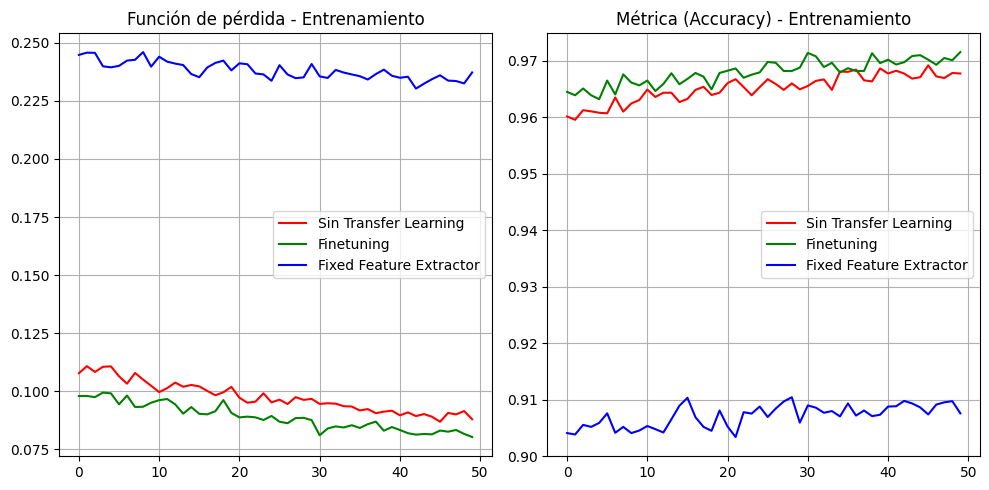

In [ ]:
graph_loss = {
    'values': [
      {
        'axy': train_loss_by_epoch_2b,
        'color': 'r'
      },
      {
        'axy': train_loss_by_epoch_ft,
        'color': 'g'
      },
      {
        'axy': train_loss_by_epoch_ffe,
        'color': 'b'
       }],
    'title': "Función de pérdida - Entrenamiento",
    'legend': ['Sin Transfer Learning', 'Finetuning', 'Fixed Feature Extractor']
}

graph_accuracy = {
    'values': [
      {
        'axy': train_acc_by_epoch_2b,
        'color': 'r'
      },
      {
        'axy': train_acc_by_epoch_ft,
        'color': 'g'
      },
      {
        'axy': train_acc_by_epoch_ffe,
        'color': 'b'
       }],
    'title': "Métrica (Accuracy) - Entrenamiento",
    'legend': ['Sin Transfer Learning', 'Finetuning', 'Fixed Feature Extractor']
}

graphResults (graph_loss, graph_accuracy)

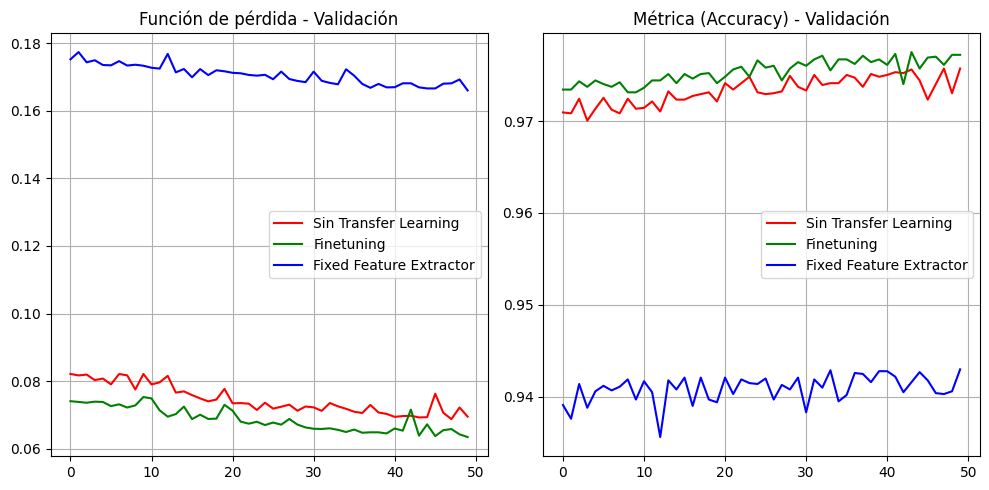

In [ ]:
graph_loss = {
    'values': [
      {
        'axy': test_loss_by_epoch_2b,
        'color': 'r'
      },
      {
        'axy': test_loss_by_epoch_ft,
        'color': 'g'
      },
      {
        'axy': test_loss_by_epoch_ffe,
        'color': 'b'
       }],
    'title': "Función de pérdida - Validación",
    'legend': ['Sin Transfer Learning', 'Finetuning', 'Fixed Feature Extractor']
}

graph_accuracy = {
    'values': [
      {
        'axy': test_acc_by_epoch_2b,
        'color': 'r'
      },
      {
        'axy': test_acc_by_epoch_ft,
        'color': 'g'
      },
      {
        'axy': test_acc_by_epoch_ffe,
        'color': 'b'
       }],
    'title': "Métrica (Accuracy) - Validación",
    'legend': ['Sin Transfer Learning', 'Finetuning', 'Fixed Feature Extractor']
}

graphResults (graph_loss, graph_accuracy)

Comparo en un gráfico de barras los tiempos de ejecución de cada uno de los tres modelos.

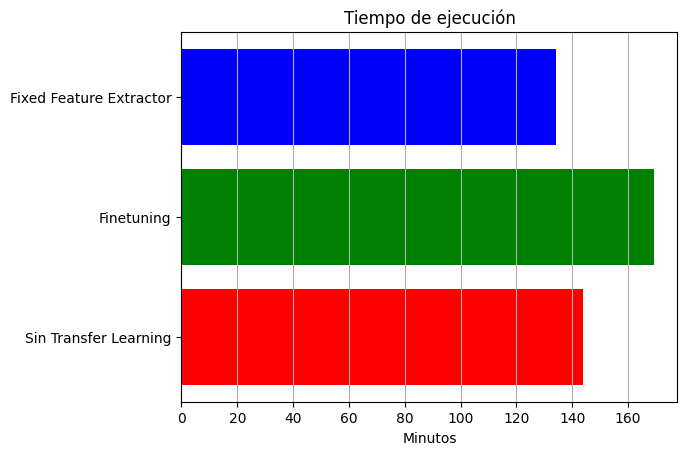

In [ ]:

models_type = ['Sin Transfer Learning', 'Finetuning', 'Fixed Feature Extractor']
time_proc = [time_2b, time_ft, time_ffe]
colors = ['r', 'g', 'b']

plt.barh(models_type, time_proc, color=colors)

plt.xlabel('Minutos')
plt.title('Tiempo de ejecución')
plt.grid(axis='x')

plt.show()

### Conclusiones

De la comparación de las gráficas resulta que, Finetuning es una mejor opción en este caso, en términos de la métrica de validación.
Sin embargo, la mejora que se observa no es tan significativa.
En general el patrón de las curvas es bastante similar, tanto el rendimiento como el aprendizaje resultan ligeramente mejor que el modelo sin Transfer Learning.

Sin embargo, con la opción de Feature Extractor, que era una alternativa que en principio consideré podría funcionar bien, con esta arquitectura los resultados no fueron los esperados.

Esto podría deberse a que, aunque Fashion-MNIST y MNIST son similares, las características aprendidas con el modelo seleccionado pueden no ser del todo relevantes para MNIST. Si el modelo ha aprendido a reconocer patrones que no son útiles para los dígitos, esto podría estar afectando al rendimiento.

Al congelar todas las capas (el modelo original que elegí tenía dos bloques de convolución), pueden haberse aprendido características específicas del dominio, y hacer que el modelo no se adapte completamente al nuevo conjunto de datos.
Una opción podría ser congelar sólo una de las dos capas, que aprendió características más generales y no tan específicas de la vestimenta.

Al ser también el conjunto de datos de MNIST más pequeño que el set de datos con los que el modelo ha sido ajustado originalmente, podría no tener información suficiente para generalizar bien.

En la comparación de los tiempos de ejecución tardó más tiempo Finetuning que Feature Extractor, lo que era esperable, ya que se entrena todo nuevamente versus entrenar una menor cantidad de parámetros congelando los valores de las primeras capas.

